In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import load_model
from sklearn.manifold import TSNE
from utils import *

In [2]:
print(tf.__version__)

2.3.1


In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [4]:
test_root = 'test/'
model_root = 'models/'
plot_root = 'beta_plots/'
ckpt_root = 'beta_vae/'

In [5]:
perplexity = [50, 100]
d = 'cosine'
learning_rate = [100]
n_iter = 1000

In [6]:
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']
easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
easy_2 = assign_labels(read_fasta(test_root + test_sets[1]))

test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
test_reads_1 = np.delete(test_reads_1, 3, axis=2)
test_reads_1 = np.expand_dims(test_reads_1, -1)

test_reads_2 = np.array(seqs2onehot(np.array(easy_2.seqs)))
test_reads_2 = np.delete(test_reads_2, 3, axis=2)
test_reads_2 = np.expand_dims(test_reads_2, -1)

beta_plots/fsize10_latentdim128_beta1e-09_30_70.png


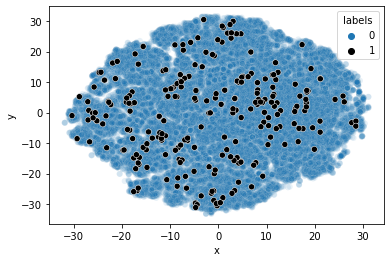

In [7]:
f_size = 10
latent_dim = 128
for beta in [10e-10]:
    filter_size = (f_size, 4)
    model_path = os.path.join(
        model_root, ckpt_root, 'fsize'+str(f_size)+'_'+'latentdim'+str(latent_dim)+'_'+'beta'+str(beta)+'_lr0.0001.h5')
    model = load_model(model_path, custom_objects={'Sampling': Sampling})
    easy_1_predictions = model.predict(test_reads_1)
    easy_2_predictions = model.predict(test_reads_2)

    embeddings_1 = easy_1_predictions[2]
    embeddings_2 = easy_2_predictions[2]
    X = np.hstack((embeddings_1, embeddings_2))
    for p in [30]:
        for lr in [70]:
            plot_path = os.path.join(plot_root, 'fsize'+str(f_size)+'_'+'latentdim'+str(latent_dim)+'_'+'beta'+str(beta)
                                     +'_'+str(p)+'_'+str(lr)+'.png')
            print(plot_path)
            clustering = TSNE(perplexity = p, metric = d, learning_rate = lr, n_iter = n_iter, verbose = 0)
            embeddings = clustering.fit_transform(X)


            df = pd.DataFrame()
            df['x'] = embeddings[:, 0]
            df['y'] = embeddings[:, 1]
            df['labels'] = easy_1.viral
            sns.scatterplot(x="x", y="y", hue="labels", data=df[df['labels']==0], alpha=0.1)
            sns.scatterplot(x="x", y="y", hue="labels", data=df[df['labels']==1], palette=['black'])
            plt.savefig(plot_path)
            plt.show()

In [30]:
# plt.hist(df[df['labels']==1]['x'])
np.median(df[df['labels']==1]['x'])#
np.max(df[df['labels']==1]['x'])

1.2331787e-08